<a href="https://colab.research.google.com/github/nurmayadi/learn-machine-learning/blob/main/sentiment_analysis_NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyek Pertama: NLP dengan tensorflow


Belajar Pengembangan Machine Learning

by: Fitra Nurmayadi

Twitter Sentiment Analysis

Source Data: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

Import Main Library

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

##Data Acquisition

Import Data

In [2]:
!pip install -q kaggle

In [3]:
import json
dictionary = {"username":"fitranurmayadi","key":"41904ce5805c3bb261bff4ae8d16a6b0"}
json_object = json.dumps(dictionary, indent=4)
with open("kaggle.json", "w") as outfile:
    outfile.write(json_object)

In [4]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

100% 1.99M/1.99M [00:01<00:00, 2.16MB/s]
100% 1.99M/1.99M [00:01<00:00, 1.88MB/s]


In [6]:
!unzip -q twitter-entity-sentiment-analysis.zip -d "sentiment-data"

In [7]:
df_train = pd.read_csv('sentiment-data/twitter_training.csv', header=None)

In [8]:
df_train.columns = ["id", "platform", "sentimen", "komentar"]

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        74682 non-null  int64 
 1   platform  74682 non-null  object
 2   sentimen  74682 non-null  object
 3   komentar  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


##Data Understanding

###Exploratory Data analysis (EDA)

####1. Class Distribution

In [10]:
#tampilkan seluruh jumlah sentimen
df_train['sentimen'].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: sentimen, dtype: int64

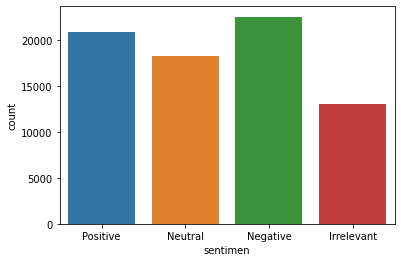

In [11]:
#Tampilkan sebaran penilaian
sns.countplot(x=df_train['sentimen'])

Tampilkan perbandingan masing-masing sentimen

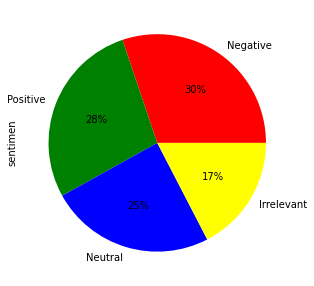

In [12]:
df_train.sentimen.value_counts().plot(
    kind='pie',
    autopct='%1.0f%%',
    figsize=(5,5),
    colors=['red', 'green','blue','yellow'])

Untuk setiap platform, tampilkan distribusi penilaian

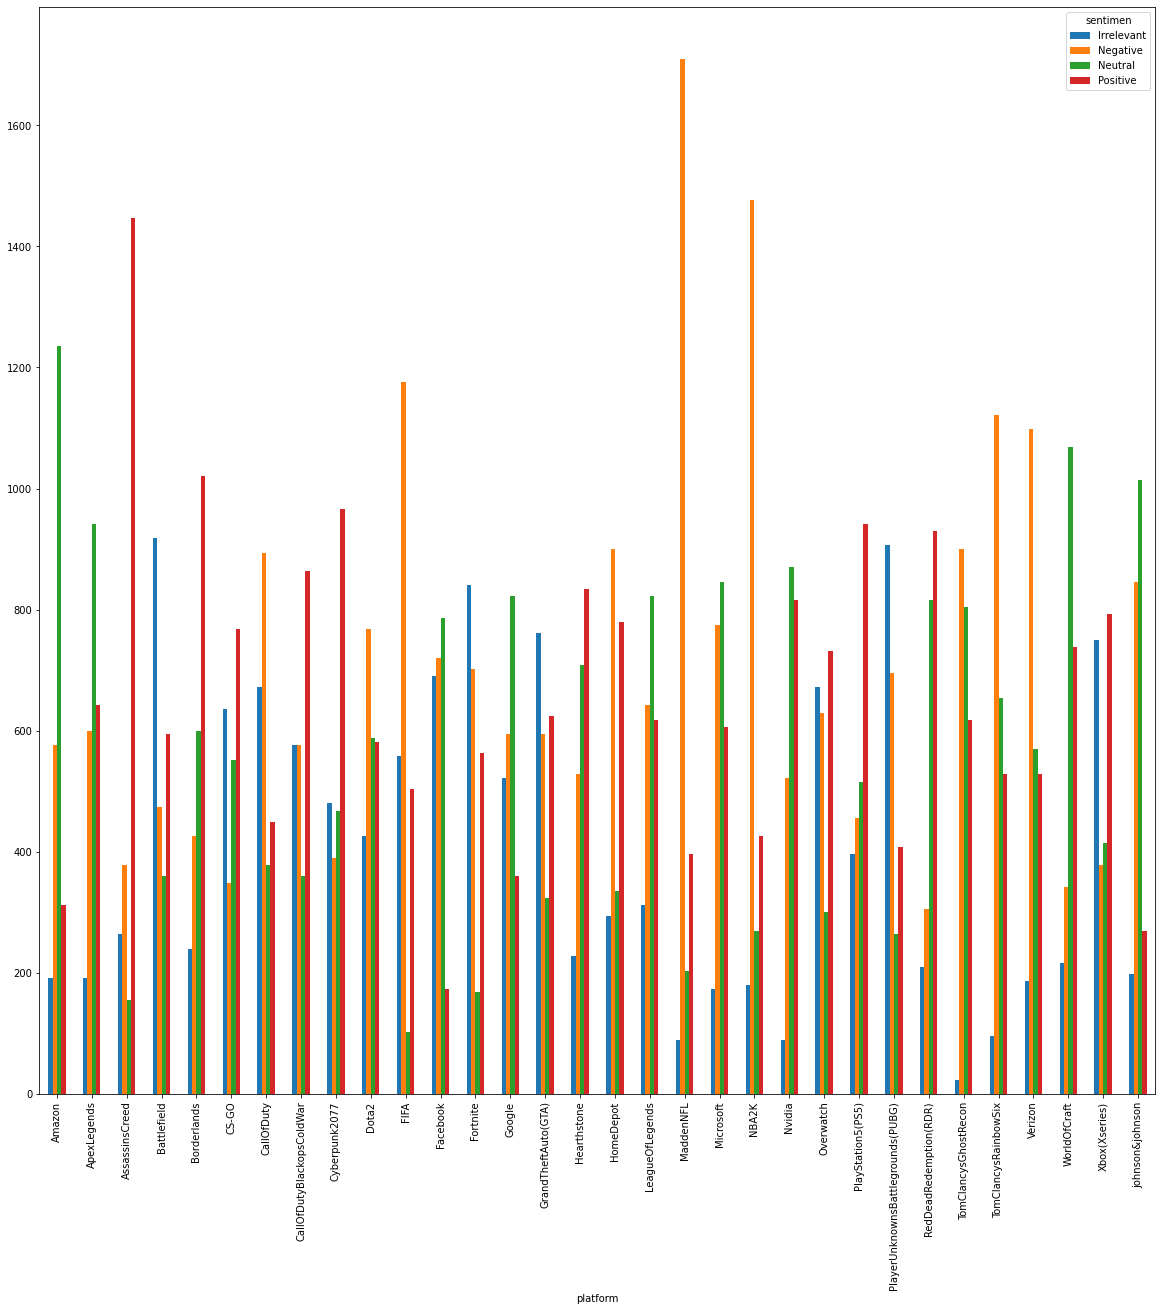

In [13]:
sentimen = df_train.groupby(['platform', 'sentimen']).sentimen.count().unstack()
sentimen.plot(kind='bar', figsize=(20,20))

####2. Missing Values

In [14]:
df_train.isna().sum()

id            0
platform      0
sentimen      0
komentar    686
dtype: int64

terlihat, ada 686 missing value

####3. Number of words

Melihat rata-rata kata dalam kalimat untuk setiap jenis sentimen

In [15]:
x=df_train['sentimen'].value_counts()
df_train['word_count'] = df_train['komentar'].apply(lambda x: len(str(x).split()))

print(df_train[df_train['sentimen']=='Negative']['word_count'].mean())
print(df_train[df_train['sentimen']=='Neutral']['word_count'].mean()) 
print(df_train[df_train['sentimen']=='Positive']['word_count'].mean()) 
print(df_train[df_train['sentimen']=='Irrelevant']['word_count'].mean())

19.89166888474847
20.02778687629654
17.052899385560675
19.466204772902234


####4. Number of Character

In [16]:
df_train['char_count'] = df_train['komentar'].apply(lambda x: len(str(x)))

print(df_train[df_train['sentimen']=='Negative']['char_count'].mean())
print(df_train[df_train['sentimen']=='Neutral']['char_count'].mean()) 
print(df_train[df_train['sentimen']=='Positive']['char_count'].mean()) 
print(df_train[df_train['sentimen']=='Irrelevant']['char_count'].mean())

110.40182769940556
117.50666011573315
95.13661674347158
109.97397998460355


##Data Cleaning

In [17]:
#hapus nilai null
df_train.dropna(inplace=True)
df_train.shape

(73996, 6)

In [18]:
#hapus sentimen 'Irrelevant'
df = df_train[df_train['sentimen']!='Irrelevant'] 

In [19]:
#Hapus kolom id dan platform
df.drop(columns=['id', 'platform', 'word_count','char_count'], inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


###Text Preprocessing

Sebelum membuat model, lakukan terlebih dahulu preproses pada dataset dengan menghapus tanda baca dan karakter khusus, membersihkan kata, menghapus kata henti, dan menggunakan lemmatisasi

***Simple text Cleaning Processes, stopword removal, Lemmatization***

In [20]:
from bs4 import BeautifulSoup 
import re
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwords = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [21]:
# funsi untuk membersihkan data
def cleaned_review(review):
    # hapus tag htlm
    new_review = BeautifulSoup(review).get_text()
    
    # hapus url
    no_urls = new_review.replace('http\S+', '').replace('www\S+', '')
    
    # hapus yang bukan huruf
    clean_review = re.sub("[^a-zA-Z]", " ", no_urls)
    
    # konversi ke huruf kecil dan tukar
    new_words = clean_review.lower().split()
    
    # set stop word untuk mempercepat
    stops = set(stopwords)
    
    # gunakna stopword untuk menghapus kata yang tidak sesui dan lakukan lematisasi
    final_words = [lemmatizer.lemmatize(word) for word in new_words if not word in stops]
    
    # kembalikan kalimat yang bersih
    return (" ".join(final_words))

buat datset baru yang telah dibersihkan

In [22]:
df['clean_text'] = df['komentar'].apply(lambda x: cleaned_review(x))
df.head()

/usr/local/lib/python3.8/dist-packages/bs4/__init__.py:270: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/bs4/__init__.py:270: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
<ipython-input-22-3cc849b562b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['komentar'].apply(lambda x: cleaned_review(x))


,sentimen,komentar,clean_text
0,Positive,im getting on borderlands and i will murder yo...,im getting borderland murder
1,Positive,I am coming to the borders and I will kill you...,coming border kill
2,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill
3,Positive,im coming on borderlands and i will murder you...,im coming borderland murder
4,Positive,im getting on borderlands 2 and i will murder ...,im getting borderland murder


In [23]:
# bandingkan data original dengan data yang dibersihkan
print(df.iloc[14045,1])
print(df.iloc[14045,2])

nah I like competitiveness better
nah like competitiveness better


<ipython-input-24-5614d7dedc71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_words'] = df['clean_text'].apply(lambda x:len(x.split()))


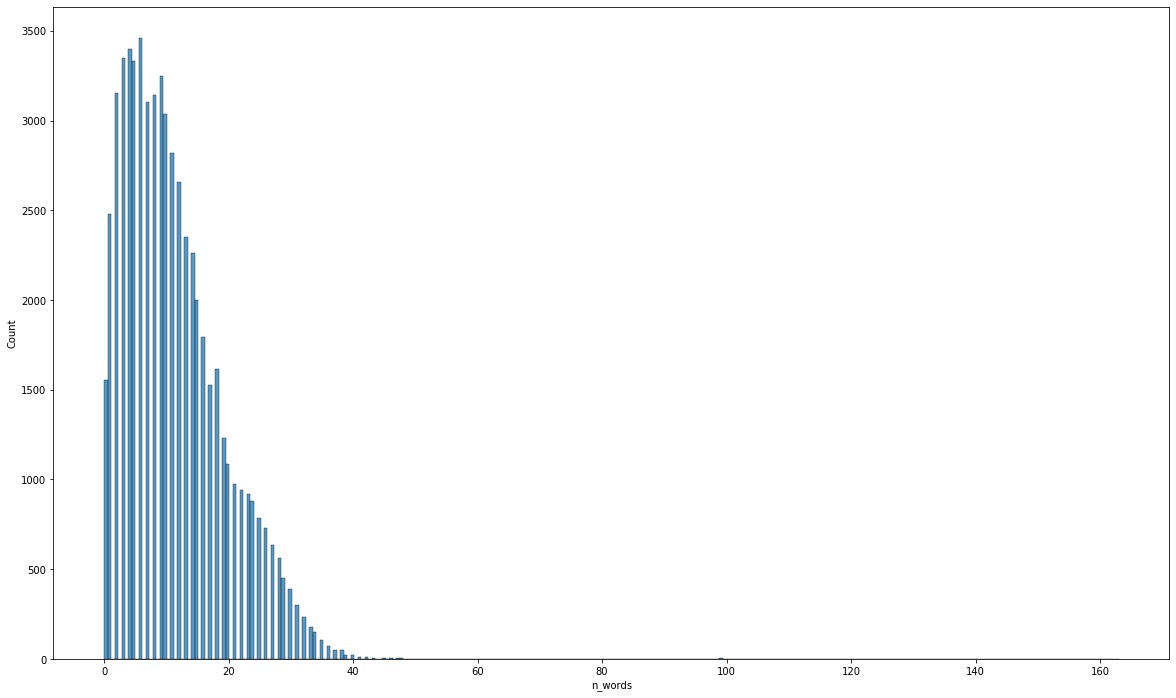

In [24]:
#Tampilkan sebaran jumlah kata setiap kalimat dalam komentar bersih
fig, ax = plt.subplots(figsize=(20, 12))

df['n_words'] = df['clean_text'].apply(lambda x:len(x.split()))
sns.histplot(data = df, x='n_words')
plt.show()

Dapat dilihat kata terbanyak dalam komentar bersih adalah sekitar 40-50

In [25]:
#buat atribut untuk diolah selanjutnya
max_len = 50

one-hot-encoding untuk nilai sentiment

In [26]:
sentiment = pd.get_dummies(df['sentimen'])
df_new = pd.concat([df, sentiment], axis = 1)
df_new.head()

,sentimen,komentar,clean_text,n_words,Negative,Neutral,Positive
0,Positive,im getting on borderlands and i will murder yo...,im getting borderland murder,4,0,0,1
1,Positive,I am coming to the borders and I will kill you...,coming border kill,3,0,0,1
2,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill,4,0,0,1
3,Positive,im coming on borderlands and i will murder you...,im coming borderland murder,4,0,0,1
4,Positive,im getting on borderlands 2 and i will murder ...,im getting borderland murder,4,0,0,1


In [27]:
#hapus kolom nilai, komentar, dan jumlah kata. tidak lagi dipakai
df_new.drop(columns=['sentimen', 'komentar','n_words'])

,clean_text,Negative,Neutral,Positive
0,im getting borderland murder,0,0,1
1,coming border kill,0,0,1
2,im getting borderland kill,0,0,1
3,im coming borderland murder,0,0,1
4,im getting borderland murder,0,0,1
...,...,...,...,...
74677,realized window partition mac like year behind...,0,0,1
74678,realized mac window partition year behind nvid...,0,0,1
74679,realized window partition mac year behind nvid...,0,0,1
74680,realized window partition mac like year behind...,0,0,1


##Data Preparation

###Tokenizer

In [28]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token='o')
tokenizer.fit_on_texts(df_new['clean_text'].values)

sequences = tokenizer.texts_to_sequences(df_new['clean_text'].values)
word_index = tokenizer.word_index

print("Ada %s token unik." %len(word_index))

Ada 23090 token unik.


###Create Attribut and Label

In [29]:
X = pad_sequences(sequences, maxlen=max_len, padding='post')
X[14045]

array([ 2214,     4, 11291,   152,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [30]:
y=df_new[['Negative', 'Neutral', 'Positive']]
y.shape

(61121, 3)

##Running ML Algorithms

###Split Dataset to Train and Test data

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=75)
x_train.shape, x_test.shape

((48896, 50), (12225, 50))

###Modelling

Sequential, Embedding, LSTM

In [32]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=23093, output_dim=50, input_length= x_train.shape[1]),
    tf.keras.layers.LSTM(50, dropout=0.25, recurrent_dropout=0.25),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax'),
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1154650   
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 78        
                                                                 
Total params: 1,176,203
Trainable params: 1,176,203
Non-trainable params: 0
_________________________________________________________________


Fungsi Callbacks

In [34]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)

###Training Dataset

In [35]:
history = model.fit(
    x_train,
    y_train,
    epochs=32,
    batch_size = 512,
    validation_split=0.1,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/32
86/86 [==============================] - 22s 207ms/step - loss: 1.0959 - accuracy: 0.3637 - val_loss: 1.0934 - val_accuracy: 0.3763
Epoch 2/32
86/86 [==============================] - 18s 204ms/step - loss: 1.0854 - accuracy: 0.3789 - val_loss: 1.0180 - val_accuracy: 0.4636
Epoch 3/32
86/86 [==============================] - 17s 199ms/step - loss: 0.8550 - accuracy: 0.5743 - val_loss: 0.7568 - val_accuracy: 0.6065
Epoch 4/32
86/86 [==============================] - 19s 225ms/step - loss: 0.6896 - accuracy: 0.6428 - val_loss: 0.6649 - val_accuracy: 0.6816
Epoch 5/32
86/86 [==============================] - 17s 199ms/step - loss: 0.6141 - accuracy: 0.7108 - val_loss: 0.5937 - val_accuracy: 0.7470
Epoch 6/32
86/86 [==============================] - 17s 202ms/step - loss: 0.5264 - accuracy: 0.7864 - val_loss: 0.6338 - val_accuracy: 0.7656
Epoch 7/32
86/86 [==============================] - 17s 198ms/step - loss: 0.4588 - accuracy: 0.8296 - val_loss: 0.5327 - val_accuracy: 0.8125

###Evaluate Model

In [36]:
model.load_weights('weights.hdf5')
loss_acc = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(loss_acc[0],loss_acc[1]))

383/383 [==============================] - 6s 15ms/step - loss: 0.5083 - accuracy: 0.8760
Test set
  Loss: 0.508
  Accuracy: 0.876


###Plotting Loss-Accuracy Train and Validation

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

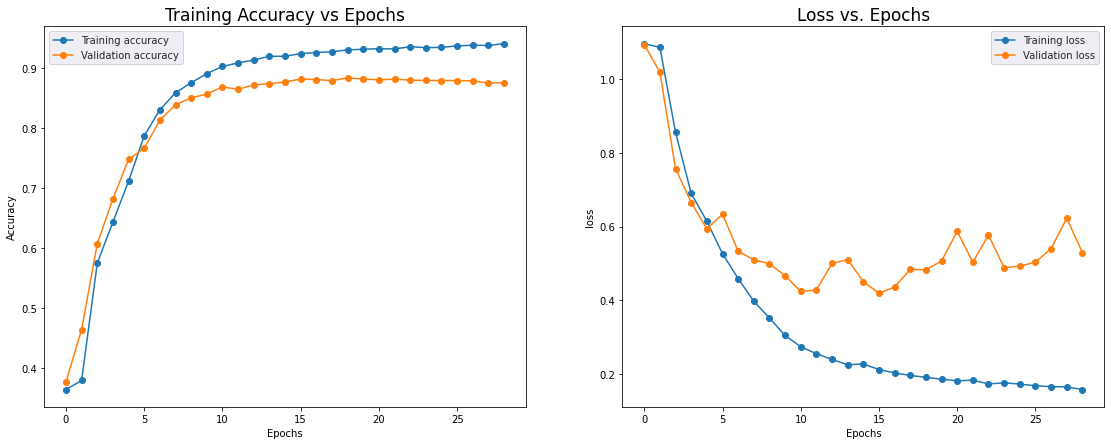

In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, 'o-',label = 'Training accuracy')
ax[0].plot(val_acc, 'o-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training Accuracy vs Epochs', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, 'o-',label = 'Training loss')
ax[1].plot(val_loss, 'o-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Loss vs. Epochs', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

Kesimpulan:
Dari Plot Loss dan Accuracy dapat dilihat model cukup mumpuni karena akurasi validasinya bisa mencapai 87%

##Test Model

Fungsi untuk melihat sentiment yang akan direspon dari sebuah kalimat

In [39]:
def find_sentiment(kalimat):
  sekuens = tokenizer.texts_to_sequences(kalimat)
  padded = pad_sequences(sekuens, padding='post',maxlen=max_len, truncating='post')
  prediksi = model.predict(padded)
  label = ['Negative', 'Neutral', 'Positive']
  return label[np.argmax(prediksi)]

In [40]:
#ambil contoh dari salah satu data
komentar = df_train['komentar'].iloc[2022]
komentar

"I'm  . . Twitch.tv/thecolorabi . . I also have a new overlay, start and BRB screens that @gr_tesque made and I worked my photoshop magic on!"

In [41]:
print(find_sentiment([komentar]))

1/1 [==============================] - 0s 262ms/step
Positive


In [42]:
#ambil contoh dari salah satu data
komentar = df_train['komentar'].iloc[2077]
komentar

'Portland supplies and houses the rioters. WTF?'

In [43]:
print(find_sentiment([komentar]))

1/1 [==============================] - 0s 28ms/step
Negative


###Tes data menggunakan data twitter_validation.csv dari sumber

In [44]:
df_test = pd.read_csv('sentiment-data/twitter_validation.csv', header=None)
df_test.columns = ['id', 'platform','sentiment','komentar']
df_test.sample(5)

,id,platform,sentiment,komentar
931,7955,MaddenNFL,Negative,@EAMaddenNFL adjust @K1 ratings you clowns dis...
935,11046,TomClancysGhostRecon,Negative,Am I the only one experiencing so many bug wit...
115,5122,GrandTheftAuto(GTA),Neutral,People who killed Michael or Trevor at the end...
424,4186,CS-GO,Neutral,Choked in an eco round 30 big L❌
91,3286,Facebook,Negative,Leaked memo excoriates #Facebook’s ‘slapdash a...


In [45]:
df_test = df_test[df_test['sentiment']!='Irrelevant']

In [46]:
df_test['clean_text'] = df_test['komentar'].apply(lambda x: cleaned_review(x))

In [47]:
df_test['predicted'] = df_test['clean_text'].apply(lambda x:find_sentiment([x]))
df_test.head(10)

1/1 [==============================] - 0s 27ms/step


,id,platform,sentiment,komentar,clean_text,predicted
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon bos jeff bezos reject claim co...,Neutral
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,microsoft pay word function poorly samsungus c...,Negative
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...,Negative
4,4433,Google,Neutral,Now the President is slapping Americans in the...,president slapping american face really commit...,Neutral
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,hi eahelp madeleine mccann cellar past year li...,Negative
6,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,thank eamaddennfl new te austin hooper orange ...,Positive
7,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",rocket league sea thief rainbow six siege love...,Positive
8,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...,as still knee deep assassin creed odyssey way ...,Positive
9,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...,fix jesus please fix world going playstation a...,Negative
10,3185,Dota2,Positive,The professional dota 2 scene is fucking explo...,professional dota scene fucking exploding comp...,Positive
